In [32]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.feature_selection import SequentialFeatureSelector
from alpha_common_functions import lineplot, residue_plot
import warnings
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')
set_config(display="diagram")


In [16]:
df = pd.read_csv("data/vehicles_v3.csv")

# Drop Columns
#### 1. title_status has least variance with almost 95% of them have 'clean' status. We will not be considering the feature in model fitting.
#### 2. 71% of records are missing size, we will thus be skipping them too.
#### 3. region has 404 distinct values, this we will only consider state for the prediction 

In [17]:
df.drop(columns=['title_status','size','region'], inplace=True)

# Train - Test Split

In [18]:
df["price_log"] = np.log(df['price'])
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price', 'price_log'], axis=1), df['price_log'], test_size = 0.3, random_state = 42)

# Answer check
print(X_train.shape)
print(X_test.shape)

(211026, 11)
(90440, 11)


# Pre Processing

![](images/PreProcessing.svg)

## Transformers

### cylinders - OrdinalEncoder
1. Similarly 15.61% od NaN will be lables as "other" and will combine with	0.24% of "other"
2. We will have total 7 unique categories
   Categories: [0.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0]
   unknown_category = 9
   missing_category = -1

In [19]:
categories_ = [[0.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0]]
unknown_categories_ = len(categories_[0])
missing_categories_ = -1

cylinders_ordinal_encoder = OrdinalEncoder(encoded_missing_value=missing_categories_, categories=categories_, unknown_value=unknown_categories_, handle_unknown='use_encoded_value')                                           

### condition - OrdinalEncoder
1. 35.44% of records have no condition provided. we will be putting all of them to new label "other"
2. We will have total 7 unique categories
   Categories: ["salvage", "fair", "good", "excellent","like new", "new"]
   unknown_category = 6
   missing_category = -1


In [20]:
categories_=[["salvage", "fair", "good", "excellent","like new", "new"]]
unknown_categories_ = len(categories_[0])
missing_categories_ = -1

condition_ordinal_encoder = OrdinalEncoder(encoded_missing_value=missing_categories_, categories=categories_, unknown_value=unknown_categories_, handle_unknown='use_encoded_value')                                           

### transmission - (SimpleImputer -> OneHotEncoder)
1. Only 0.33% of all records are null. We do have additional category of "other" which is 18%+. Thus we will add 0.33%  of null as "other"
2. This will narrow down the transmossion to just 3 subcategories
### fuel - (SimpleImputer -> OneHotEncoder)
1. 0.07% of nissing values will be combined with 7.88% of "others"
2. We will have total 5 unique categories
### type - (SimpleImputer -> OneHotEncoder)
1. 15.21 of NaN will be combined with 5.37% of Other
2. In Total 12 categories will be remaining
### drive - (SimpleImputer -> OneHotEncoder)
1. 26.31% of NaN will be renamed as "Others
2. Total remaining categories will be 4
### paint_color - (SimpleImputer -> OneHotEncoder)
1. 28.19% of NaN will be renamed as "Others
2. Total remaining categories will be 13

In [21]:
simple_imputer = SimpleImputer(strategy='constant', fill_value='other')

<div class="alert alert-block alert-success">
    <font size=6 color='black'>
        Model 2
    </font>
    <br>
    <font size=5 color='black'>
    <u>Transformation + PolynomialFeature (all fields) + Linear Regression</u>
    </font>
    <br>
    <font size=4 color='black'>
    1. Transformation    <br>
    * SimpleImputer -> OneHotEncoder on 'transmission','fuel', 'type', 'drive', 'paint_color' <br>
    * Plain OneHotEncoder on 'manufacturer','state'<br>
    * OrdinalEncoder on 'condition' and 'cylinders' <br>
    * StandardScaler and the PolynomialFeatures on 'year', 'odometer'<br>
    2. Apply PolynomialFeatures(degree=2) on all the transformed fields  <br>  
    </font>
</div>

In [22]:
transformer = make_column_transformer(
    (Pipeline([
        ('simple_imputer', simple_imputer),
        ('one_hot_encoder', OneHotEncoder())
    ]),['transmission','fuel', 'type', 'drive', 'paint_color']),
    (OneHotEncoder(),['manufacturer','state']),
    (condition_ordinal_encoder, ['condition']), 
    (cylinders_ordinal_encoder, ['cylinders']),
    remainder=StandardScaler())

In [23]:
pipe = Pipeline([('transformer', transformer), ('poly', PolynomialFeatures(include_bias = False, degree = 2)), ('regression', LinearRegression())])

In [24]:
pipe.fit(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']], y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='other',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['transmission', 'fuel',
                                                   'type', 'drive',
                                                   'paint_color']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'state']),
                                                 ('ordina...
                                                                 encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=6),
                                                  ['condition']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[[0.0,
                                                                              3.0,
                                                                              4.0,
                                                                              5.0,
                                                                              6.0,
                                                                              8.0,
                                                                              10.0,
                                                                              12.0]],
                                                                 encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=8),
                                                  ['cylinders'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('regression', LinearRegression())])

In [25]:
y_train_predict = pipe.predict(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
y_test_predict = pipe.predict(X_test[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
#predict on train and test
train_mses=(mean_squared_error(y_train, y_train_predict))
test_mses=(mean_squared_error(y_test, y_test_predict))

In [26]:
print(train_mses)
print(test_mses)

0.10089783922900376
0.10689198652446408


In [27]:
r2_score(y_test, y_test_predict)

0.83516198583824

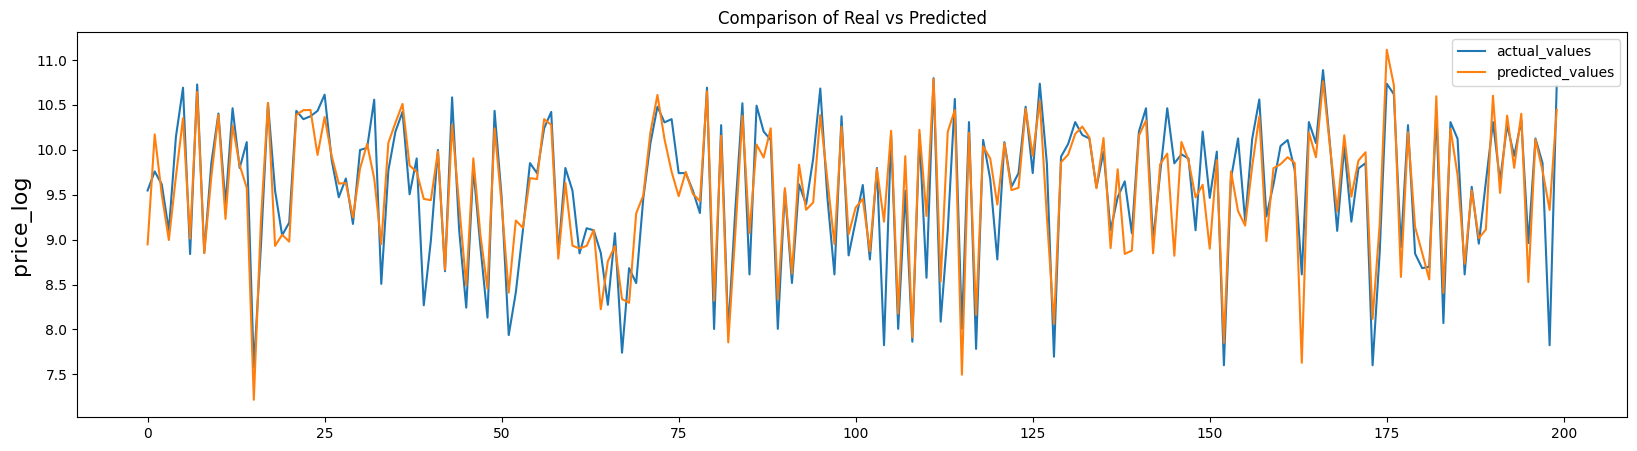

In [30]:
lineplot(y_test, y_test_predict, 200, "PolynomialFeatureson_All_Fields")

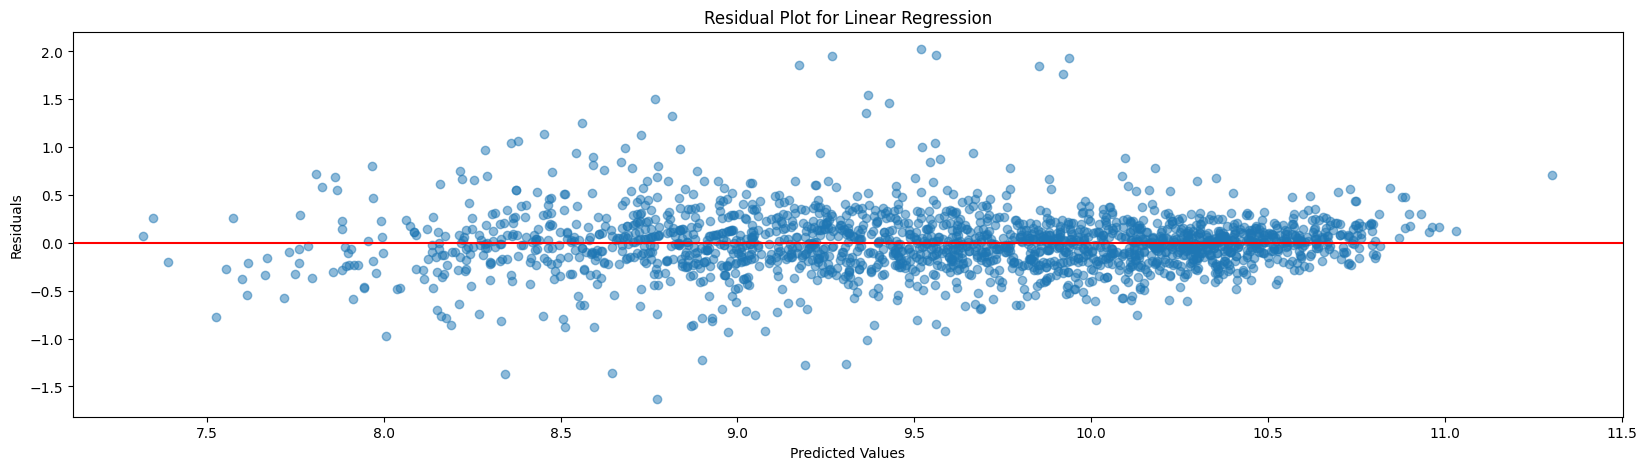

In [33]:
residue_plot(y_test, y_test_predict, 200, "PolynomialFeatureson_All_Fields")

In [34]:
len(pipe.named_steps['regression'].coef_)

9179

In [35]:
len(pipe.named_steps['poly'].get_feature_names_out())

9179

<div class="alert alert-block alert-warning">
    <font size=5, color='black'>
        Model 2
    </font>
    <br>
    <font size=3 color='black'>
    * Even though the MSE for both training and test have decreased, its not much advised to have a fitting on 9179 features. It is very heavy in terms of computation.<br>
    </font>
</div>

---

<div class="alert alert-block alert-success">
    <font size=6 color='black'>
        Model 3
    </font>
    <br>
    <font size=5 color='black'>
    <u>PolynomialFeatures</u>
    </font>
    <br>
    <font size=4 color='black'>
    Focus on this section will be on<br> 
    * SimpleImputer -> OneHotEncoder on 'transmission','fuel', 'type', 'drive', 'paint_color'<br>
    * Plain OneHotEncoder on 'manufacturer','state'<br>
    * OrdinalEncoder -> PolynomialFeatures (degree=2) on 'condition' and 'cylinders' in respective parallel pipeline<br>
    * StandardScaler and the PolynomialFeatures on 'year', 'odometer'<br>
    </font>
    </p>
</div>

In [36]:
transformer = make_column_transformer(
    (Pipeline([
        ('simple_imputer', simple_imputer),
        ('one_hot_encoder', OneHotEncoder())
    ]),['transmission','fuel', 'type', 'drive', 'paint_color']),
    (OneHotEncoder(),['manufacturer','state']),
    (Pipeline([
        ('ordinal',cylinders_ordinal_encoder), 
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))]), ['cylinders']),     
    (Pipeline([
        ('ordinal',condition_ordinal_encoder), 
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))]), ['condition']),     
    (Pipeline([
        ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))
    ]) , ['year', 'odometer']),
    remainder='passthrough')

In [37]:
pipe = Pipeline([('transformer', transformer), ('regression', LinearRegression())])

In [38]:
pipe.fit(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']], y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='other',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['transmission', 'fuel',
                                                   'type', 'drive',
                                                   'paint_color']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'state']),
                                                 ('pipelin...
                                                                                               'fair',
                                                                                               'good',
                                                                                               'excellent',
                                                                                               'like '
                                                                                               'new',
                                                                                               'new']],
                                                                                  encoded_missing_value=-1,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=6)),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['condition']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['year', 'odometer'])])),
                ('regression', LinearRegression())])

In [39]:
y_train_predict = pipe.predict(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
y_test_predict = pipe.predict(X_test[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
#predict on train and test
train_mses=(mean_squared_error(y_train, y_train_predict))
test_mses=(mean_squared_error(y_test, y_test_predict))

In [40]:
print(train_mses)
print(test_mses)

0.13856419831479289
0.13928200685942604


In [41]:
len(pipe.named_steps['transformer'].get_feature_names_out())

139

In [42]:
r2_score(y_test, y_test_predict)

0.7852133713136872

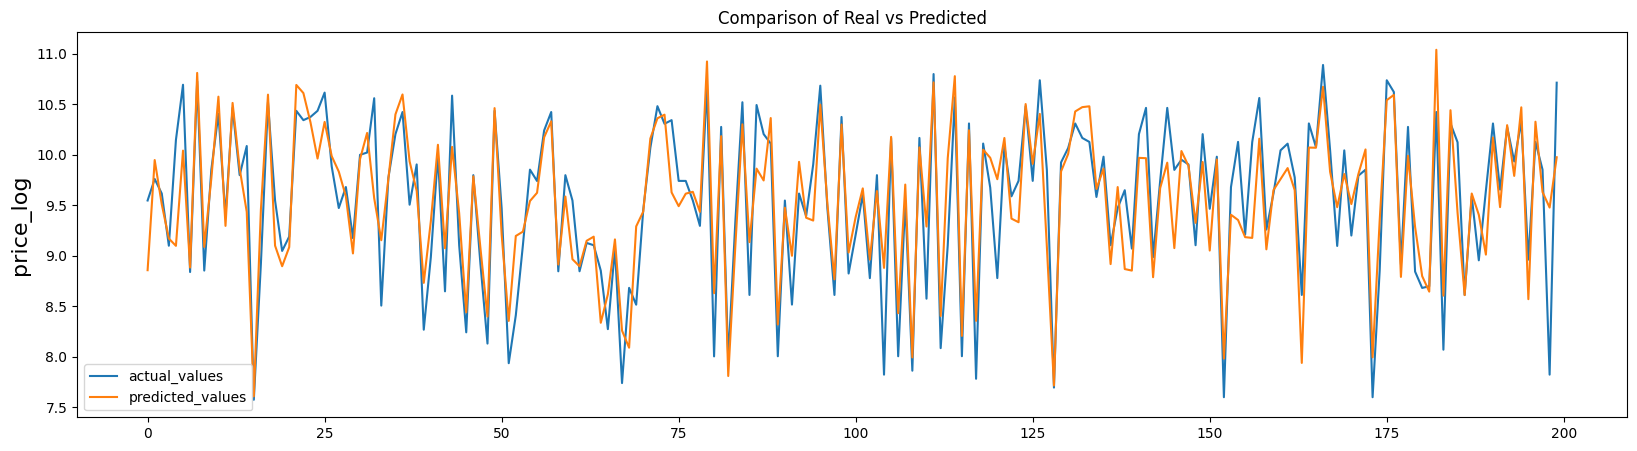

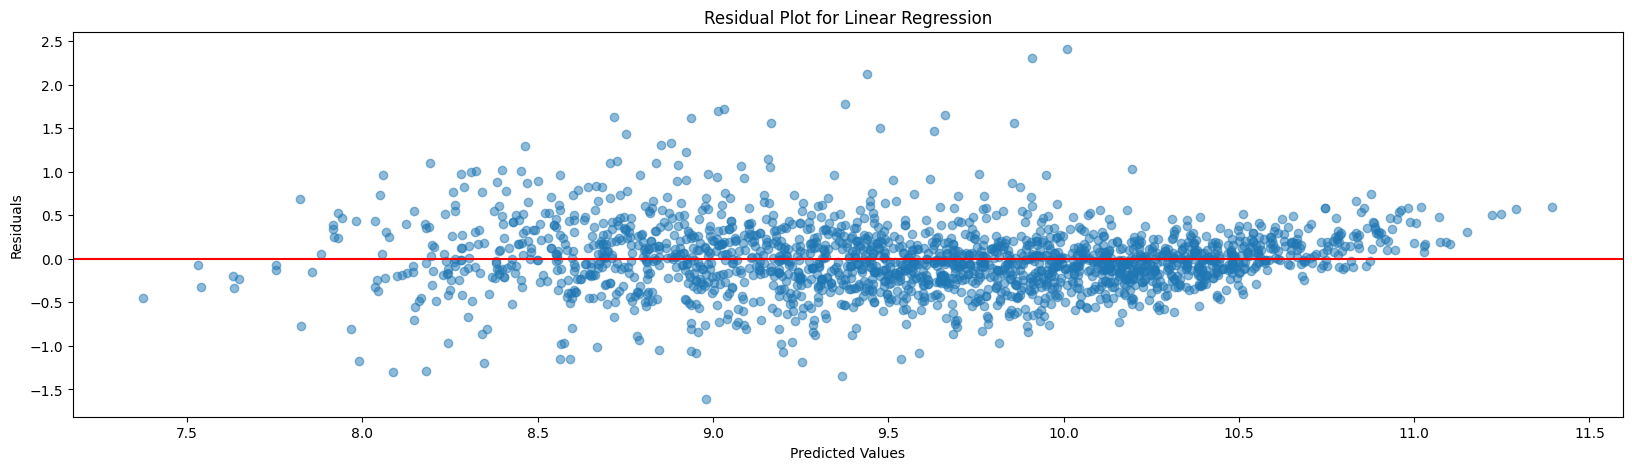

In [43]:
lineplot(y_test, y_test_predict, 200, "PolynomialFeatureson_4_Fields")
residue_plot(y_test, y_test_predict, 200, "PolynomialFeatureson_4_Fields")

<div class="alert alert-block alert-warning">
    <font size=5, color='black'>
        Model 3
    </font>
    <br>
    <font size=3 color='black'>
    * Even though the MSE for both training and test have increased, its much advised to have a fitting on 139 features.<br>
    * The MSEs are better than doing PolyNomialFeature on just 2 fields<br>
    </font>
</div>